The goal of this assignment is to classify documents in a corpus. You will train a variety of tree-based models and evaluate each one using 5-fold cross-validation. Using your best performing model, you will run inference on a test set and submit the predicted labels.
Dataset description:

You will use the news dataset from Assignment 1. As before, the dataset contains five categories( sport, business, politics, entertainment, tech). The task is to classify documents to one of these five categories. You will be provided with the following datasets:
Raw training data (link) with labels:
The dataset contains raw text of 1490 news articles and the article category. Each row is a document.
The raw file is a .csv with three columns: ArticleId, Text, Category 
The “Category” column are the labels you will use for training
Raw test data (link) without labels
This dataset contains raw text of 736 news articles. Each row is a document.
The raw file is a .csv with two columns: ArticleId,Text. 
The labels are not provided

Your job:
Preprocess the raw training data. You can use your code from assignment one. Additionally, you can use the code from the posted solution from assignment 1 (see below). You may also construct other features, such n-grams or keyword extractions. Feel free to use any other features you feel may be relevant. 
Evaluate the decision tree model on your pre-processed data.
Randomly select 80% data instances as training, and the remaining 20% data instances as validation. Change the parameter setting on criterion (“gini”, “entropy”}. Draw a figure showing the training error and validation error w.r.t. different parameter values
Evaluate the decision tree using 5-fold cross-validation. Draw a figure showing the average training error and average validation error w.r.t. different parameter values. The parameters you should tune include: criterion, min_samples_leaf, and max_features (as int). We recommend Google Colab and scikit-learn package (see the example codes on Schedule page).

Evaluate random forests model on pre-processed training data.
Describe your parameter setting. 
Use 5-fold cross-validation to evaluate the performance w.r.t. the number of trees (n_estimators). 
Report the average accuracy and standard deviation for different parameter values (organize the results in a table).
Draw a figure showing the result.

Evaluate XGBoost on pre-processed training data.
Describe your parameter setting. 
Use 5-fold cross-validation to evaluate the performance w.r.t. eta (the learning rate). 
Report the average accuracy and standard deviation for different parameter values (organize the results in a table).
Draw a figure showing the result.

Predict the labels for the testing data (using raw training data and raw testing data).  
Describe how you pre-process the data to generate features. 
Describe how you choose the model and parameters.  
Describe the performance of your chosen model and parameter on the training data.
The final classification models to be used in this question are limited to decision tree, random forest, and boosting trees. It is OK to use other models to do feature engineering (e.g., using neural nets for word embedding).  

Note that this question will be graded based on your accuracy. You should try to think of better features and try different models and parameters in order to get a higher accuracy.
 

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from six.moves import urllib 
import string 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem.porter import * 
from tqdm import tqdm
from matplotlib import pyplot as plt
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
URL = 'https://wikispaces.psu.edu/download/attachments/395383213/news-train.csv?api=v2'
LOCAL_FOLDER = 'datasets'
NEWS_TRAIN = 'news_train.csv'
NEWS_PATH = os.path.join(LOCAL_FOLDER, NEWS_TRAIN)
os.makedirs(LOCAL_FOLDER, exist_ok = True)
urllib.request.urlretrieve(URL, NEWS_TRAIN)
def load_news_train(news_path=NEWS_PATH):
    csv_path = os.path.join(news_path)
    return pd.read_csv(csv_path)
news_train = load_news_train()

In [2]:
URL2 = 'https://wikispaces.psu.edu/download/attachments/395383213/dictionary.txt?api=v2'
LOCAL_FOLDER = 'datasets'
DICTIONARY = 'dictionary.txt'
DICTIONARY_PATH = os.path.join(LOCAL_FOLDER, DICTIONARY)
os.makedirs(LOCAL_FOLDER, exist_ok=True)
urllib.request.urlretrieve(URL2, DICTIONARY_PATH)
def open_dictionary(dictionary_path=DICTIONARY_PATH):
    csv_path = os.path.join(dictionary_path)
    return pd.read_csv(csv_path)
dictionary = open_dictionary()

In [3]:
URL3 = 'https://wikispaces.psu.edu/download/attachments/395383213/news-test.csv?api=v2'
LOCAL_FOLDER = 'datasets'
UNLABELED = 'unlabeled.csv'
UNLABELED_PATH = os.path.join(LOCAL_FOLDER, UNLABELED)
os.makedirs(LOCAL_FOLDER, exist_ok=True)
urllib.request.urlretrieve(URL3,UNLABELED_PATH)
def open_unlabeled(unlabeled=UNLABELED_PATH):
    csv_path = os.path.join(unlabeled)
    return pd.read_csv(csv_path)
news_test = open_unlabeled()

In [4]:
def load_data(file):
    with open(file, 'r') as f:
        lines = f.readlines()

    return lines
news_data = load_data('datasets/news_train.csv')

In [5]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuation
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # stop words
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    # stemming process
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed

[nltk_data] Downloading package punkt to /Users/anon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/anon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import numpy as np


def get_dict(fpath):
    dictionary = {}


    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i

    return dictionary


def get_doc_tf(word_set, dictionary):
    n_words = len(dictionary)
    tf_vec = np.zeros(n_words)

    max_cnt = 0
    for word in word_set:
        idx = dictionary[word]
        tf_vec[idx] += 1.0

        if tf_vec[idx] > max_cnt:
            max_cnt = tf_vec[idx]

    return tf_vec / max_cnt



def get_tf_idf(tf_dict, df_vec, n_doc, n_words):

    tf_idf_mtx = np.zeros((n_doc, n_words))
    idf = np.log(n_doc / df_vec)

    for doc_idx, tf_vec in tf_dict.items():
        tf_idf = tf_dict[doc_idx]*idf

        tf_idf_mtx[doc_idx, :] = tf_idf

    return tf_idf_mtx


def write(d, fpath):

    with open(fpath, "w") as f:

        for k, v in d.items():

            f.write(f"{k}\n")


def filter_top_k(counter_sorted, limit):
    top_k = {}

    for i, k in enumerate(counter_sorted.keys()):
        if i == limit:
            break
        top_k[k] = counter_sorted[k]

    return top_k

In [7]:
def tfidf_main(fpath, dictionary):


    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:
                continue

            doc_idx = i - 1

            id, txt, cat = line.split(",")
            cat = cat.strip()
            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)

            # get term frequency
            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec

            # get doc frequency:
            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1


    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)


    return tfidf_mtx

In [8]:
def tfidf2(fpath, dictionary):


    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:
                continue

            doc_idx = i - 1

            id, txt = line.split(",")
            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)

            # get term frequency
            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec

            # get doc frequency:
            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1


    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)


    return tfidf_mtx

In [9]:
dictionary = get_dict(DICTIONARY_PATH)
tfidf = tfidf_main(NEWS_PATH, dictionary)
np.savetxt("datasets/tfidf.txt", tfidf,  fmt='%.4f', delimiter=",")

100%|██████████| 1491/1491 [01:02<00:00, 23.82it/s]


In [10]:
def frequency_main(limit, fpath, dictionary):



    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines)

        stratifed_cntr = {
                        "sport": {},
                        "business": {},
                        "politics": {},
                        "entertainment": {},
                        "tech": {}
                    }


        for i, line in tqdm(enumerate(lines), total=n_doc + 1):
            if i == 0:
                continue

            id, txt, cat = line.split(",")
            cat = cat.strip()
            tokens = get_tokens(txt)

            for t in tokens:
                if t not in dictionary:
                    continue

                if t not in stratifed_cntr[cat]:
                    stratifed_cntr[cat][t] = 0

                stratifed_cntr[cat][t] += 1

        stratifed_sorted = {}
        for cat, cnts in stratifed_cntr.items():
            stratifed_sorted[cat] = {k: v for k, v in sorted(cnts.items(), key=lambda item: item[1], reverse=True)}


        stratified_output = {}
        for cat, cnts in stratifed_sorted.items():
            stratified_output[cat] = filter_top_k(cnts, limit)

    return stratified_output

In [11]:
counts = frequency_main(limit=50, fpath=NEWS_PATH, dictionary=dictionary)

100%|█████████▉| 1491/1492 [01:05<00:00, 22.64it/s]


In [12]:
counts

{'sport': {'said': 635,
  'game': 482,
  'win': 419,
  'play': 416,
  'england': 327,
  'first': 323,
  'player': 308,
  'year': 296,
  'time': 270,
  'world': 266,
  'last': 258,
  'two': 253,
  'back': 243,
  'one': 241,
  'would': 233,
  'match': 228,
  'go': 223,
  'side': 218,
  'also': 214,
  'cup': 206,
  'second': 204,
  'open': 203,
  'team': 203,
  'new': 198,
  'take': 197,
  'champion': 196,
  'ireland': 194,
  'final': 190,
  'get': 184,
  'wale': 183,
  'good': 180,
  'coach': 176,
  'could': 171,
  'six': 169,
  'start': 168,
  'club': 167,
  'nation': 166,
  'minut': 164,
  'season': 164,
  'like': 162,
  'three': 161,
  'make': 159,
  'franc': 158,
  'set': 158,
  'tri': 158,
  'chelsea': 157,
  'injuri': 155,
  'week': 152,
  'made': 148,
  'want': 146},
 'business': {'said': 1100,
  'year': 574,
  'us': 511,
  'mr': 394,
  'compani': 392,
  'firm': 374,
  'market': 352,
  'would': 308,
  'bank': 281,
  'also': 279,
  'sale': 276,
  'new': 273,
  'growth': 257,
  'eco

In [13]:
def mean_tfidf_main(trn_fpath, tfidf_fpath, dictionary, k):

    idx_to_word = {}
    for key, val in dictionary.items():
        idx_to_word[val] = key

    with open(trn_fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1
        cats = np.zeros((n_doc, 1), dtype=object)

        for i, line in tqdm(enumerate(lines), total=n_doc + 1):
            if i == 0:
                continue

            doc_idx = i - 1
            id, txt, cat = line.split(",")
            cat = cat.strip()

            cats[doc_idx, 0] = cat

        tfidf = np.loadtxt(tfidf_fpath, delimiter=",")

        df = pd.DataFrame(np.concatenate([cats, tfidf], axis=1))

        groups = df.groupby(0)

        output = {}

        for cat, chunk in groups:

            mean = chunk.values[:, 1:].mean(axis=0)

            word_idx = np.argsort(mean)
            s = np.sort(mean)
            top_k = word_idx[-k:]

            output[cat] = {}
            for idx in top_k:
                word = idx_to_word[idx]
                score = mean[idx]
                #record = {"word": word, "score": score}
                output[cat][word] = score


    return output

In [14]:
avg_tfidf = mean_tfidf_main(NEWS_PATH, "datasets/tfidf.txt", dictionary, k=1490)

100%|██████████| 1491/1491 [00:00<00:00, 494481.48it/s]


In [15]:
avg_tfidf.keys()

dict_keys(['business', 'entertainment', 'politics', 'sport', 'tech'])

In [16]:
df = news_train[['Text', 'Category']]
df.shape

(1490, 2)

In [17]:
def encode_and_add_column (data, column, new_column):
    from sklearn.preprocessing import OrdinalEncoder
    ordinal_encoder = OrdinalEncoder()
    encoded_column = ordinal_encoder.fit_transform(data[[column]])
    data[new_column] = encoded_column
def clean_column(string):
    string = string.lower()
    return string

In [18]:
encode_and_add_column(df, 'Category', 'Category_Id')
cleaned_columns = []
for column in df.columns:
    clean_columns = clean_column(column)
    cleaned_columns.append(clean_columns)
df_clean = df.copy()
df_clean.columns = cleaned_columns

In [19]:
df_clean

,text,category,category_id
0,worldcom ex-boss launches defence lawyers defe...,business,0.0
1,german business confidence slides german busin...,business,0.0
2,bbc poll indicates economic gloom citizens in ...,business,0.0
3,lifestyle governs mobile choice faster bett...,tech,4.0
4,enron bosses in $168m payout eighteen former e...,business,0.0
...,...,...,...
1485,double eviction from big brother model caprice...,entertainment,1.0
1486,dj double act revamp chart show dj duo jk and ...,entertainment,1.0
1487,weak dollar hits reuters revenues at media gro...,business,0.0
1488,apple ipod family expands market apple has exp...,tech,4.0


In [20]:
categories_id = df_clean[['category', 'category_id']].drop_duplicates()
category_dict = dict(zip(categories_id.category_id, categories_id.category))
category_dict

{0.0: 'business',
 4.0: 'tech',
 2.0: 'politics',
 3.0: 'sport',
 1.0: 'entertainment'}

In [21]:
prepared_df = df_clean.copy()
prepared_df.drop('category', axis=1, inplace=True)
prepared_df.set_index('category_id', inplace=True)
prepared_dict = dict(zip(prepared_df.index, prepared_df.text))

In [22]:
dictionary = dict(prepared_df)
dictionary

{'text': category_id
 0.0    worldcom ex-boss launches defence lawyers defe...
 0.0    german business confidence slides german busin...
 0.0    bbc poll indicates economic gloom citizens in ...
 4.0    lifestyle  governs mobile choice  faster  bett...
 0.0    enron bosses in $168m payout eighteen former e...
                              ...                        
 1.0    double eviction from big brother model caprice...
 1.0    dj double act revamp chart show dj duo jk and ...
 0.0    weak dollar hits reuters revenues at media gro...
 4.0    apple ipod family expands market apple has exp...
 4.0    santy worm makes unwelcome visit thousands of ...
 Name: text, Length: 1490, dtype: object}

In [23]:
categories = dict(categories_id.values)

In [24]:
df_clean['category_id']
df_clean['text']

0       worldcom ex-boss launches defence lawyers defe...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens in ...
3       lifestyle  governs mobile choice  faster  bett...
4       enron bosses in $168m payout eighteen former e...
                              ...                        
1485    double eviction from big brother model caprice...
1486    dj double act revamp chart show dj duo jk and ...
1487    weak dollar hits reuters revenues at media gro...
1488    apple ipod family expands market apple has exp...
1489    santy worm makes unwelcome visit thousands of ...
Name: text, Length: 1490, dtype: object

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                       ngram_range=(1,2), stop_words = 'english')


features = tfidf.fit_transform(prepared_df.text).toarray()

labels = df_clean.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1490 complaints is represented by 9927 features (TF-IDF score of unigrams and bigrams)


In [26]:
N = 3
for index, category_id in sorted(categories.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(index))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> business:
  * Most Correlated Unigrams are: growth, bank, shares
  * Most Correlated Bigrams are: stock market, economic growth, analysts said

==> entertainment:
  * Most Correlated Unigrams are: singer, actor, film
  * Most Correlated Bigrams are: won best, los angeles, box office

==> politics:
  * Most Correlated Unigrams are: blair, election, labour
  * Most Correlated Bigrams are: prime minister, tony blair, mr blair

==> sport:
  * Most Correlated Unigrams are: match, coach, cup
  * Most Correlated Bigrams are: grand slam, champions league, australian open

==> tech:
  * Most Correlated Unigrams are: technology, software, users
  * Most Correlated Bigrams are: anti virus, mobile phones, mobile phone


In [27]:
from sklearn.model_selection import train_test_split
X = prepared_df['text']
y = df_clean['category']


train_val_data, test_data, train_val_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
len(news_test['Text'])

735

In [29]:
##########################
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
train_val_X = vectorizer.fit_transform(train_val_data)
test_X = vectorizer.transform(test_data)
testing = vectorizer.transform(news_test['Text'])
##########################

print(train_val_X.shape)
print(test_X.shape)
print(testing.shape)

(1192, 22591)
(298, 22591)
(735, 22591)


In [30]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold



dtc = DecisionTreeClassifier()
dtc_1 = DecisionTreeClassifier(min_samples_leaf = 2, max_features=5000, max_depth = 125)
dtc_ent = DecisionTreeClassifier(criterion='entropy', max_depth = 50)
dtc_ent_1 = DecisionTreeClassifier(max_depth = 150, criterion='entropy', min_samples_leaf = 5, max_features=7500)
xgb = XGBClassifier()

In [31]:
#training DecisionTree models with different parameter settings
dtc.fit(train_val_X, train_val_y) #gini

DecisionTreeClassifier()

In [32]:
dtc_1.fit(train_val_X, train_val_y) #gini, min_samples_leaf=4, max_features=20

DecisionTreeClassifier(max_depth=125, max_features=5000, min_samples_leaf=2)

In [33]:
dtc_ent.fit(train_val_X, train_val_y) #entropy

DecisionTreeClassifier(criterion='entropy', max_depth=50)

In [34]:
dtc_train_predictions = dtc.predict(test_X)

In [35]:
dtc_ent_1.fit(train_val_X, train_val_y) #entropy, min_samples_leaf = 2, max_features=20

DecisionTreeClassifier(criterion='entropy', max_depth=150, max_features=7500,
                       min_samples_leaf=5)

In [36]:
dtc_scores = cross_val_score(dtc, train_val_X, train_val_y, cv=5)
print(dtc_scores)
dtc_1_scores = cross_val_score(dtc_1, train_val_X, train_val_y, cv=5)
print(dtc_1_scores)
dtc_ent_scores = cross_val_score(dtc_ent, train_val_X, train_val_y, cv=5)
print(dtc_ent_scores)
dtc_ent_1_scores = cross_val_score(dtc_ent_1, train_val_X, train_val_y, cv=5)
print(dtc_ent_1_scores)

[0.80334728 0.74476987 0.76470588 0.78571429 0.7394958 ]
[0.73221757 0.73640167 0.78991597 0.73109244 0.76470588]
[0.76150628 0.73640167 0.75210084 0.78571429 0.73109244]
[0.76150628 0.68200837 0.68907563 0.70588235 0.71848739]


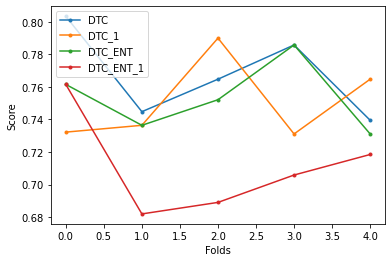

In [37]:
plt.plot(dtc_scores, marker = '.', label='DTC')
plt.plot(dtc_1_scores, marker='.', label='DTC_1')
plt.plot(dtc_ent_scores, marker='.', label='DTC_ENT')
plt.plot(dtc_ent_1_scores, marker='.', label='DTC_ENT_1')
plt.xlabel('Folds')
plt.ylabel('Score')
plt.legend()

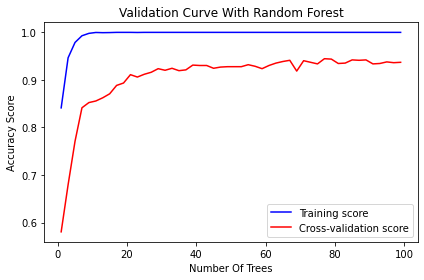

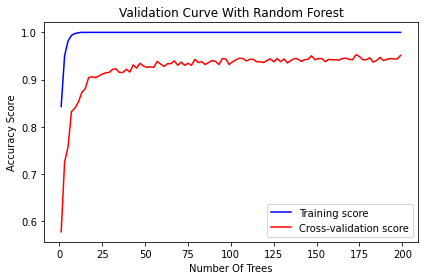

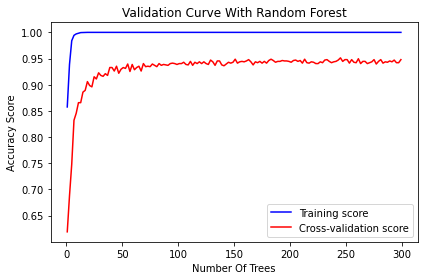

In [38]:
from sklearn.model_selection import validation_curve
param_range = np.arange(1, 100, 2)
train_scores, test_scores = validation_curve(RandomForestClassifier(),X = train_val_X, y = train_val_y,param_name = 'n_estimators',
                                                 param_range =param_range, cv = 5,scoring="accuracy", 
                                             n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()


#validation curve with different parameters; n_estimators=200
param_range2 = np.arange(1, 200, 2)
train_scores2, test_scores2 = validation_curve(RandomForestClassifier(n_estimators=200),X = train_val_X, y = train_val_y,param_name = 'n_estimators',
                                                 param_range =param_range2, cv = 5,scoring="accuracy", 
                                             n_jobs=-1)
train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)
test_mean2 = np.mean(test_scores2, axis=1)
test_std2 = np.std(test_scores2, axis=1)
plt.plot(param_range2, train_mean2, label="Training score", color="blue")
plt.plot(param_range2, test_mean2, label="Cross-validation score", color="red")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

param_range3 = np.arange(1, 300, 2)
train_scores3, test_scores3 = validation_curve(RandomForestClassifier(n_estimators=300),X = train_val_X, y = train_val_y,param_name = 'n_estimators',
                                                 param_range =param_range3, cv = 5,scoring="accuracy", 
                                             n_jobs=-1)
train_mean3 = np.mean(train_scores3, axis=1)
train_std3 = np.std(train_scores3, axis=1)
test_mean3 = np.mean(test_scores3, axis=1)
test_std3 = np.std(test_scores3, axis=1)
plt.plot(param_range3, train_mean3, label="Training score", color="blue")
plt.plot(param_range3, test_mean3, label="Cross-validation score", color="red")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [39]:
rf_scores = cross_val_score(RandomForestClassifier(), train_val_X, train_val_y,
                            scoring = 'accuracy', cv=5)
rf_scores2 = cross_val_score(RandomForestClassifier(n_estimators=200), train_val_X, train_val_y,
                            scoring = 'accuracy', cv=5)
rf_scores3 = cross_val_score(RandomForestClassifier(n_estimators=300), train_val_X, train_val_y,
                            scoring = 'accuracy', cv=5)
rf_scores4 = cross_val_score(RandomForestClassifier(n_estimators=400), train_val_X, train_val_y,
                            scoring = 'accuracy', cv=5)
rf_scores5 = cross_val_score(RandomForestClassifier(n_estimators=500), train_val_X, train_val_y,
                            scoring = 'accuracy', cv=5)
rf_std = rf_scores.std()
rf_acc = rf_scores.mean()*100
rf_std2 = rf_scores2.std()
rf_acc2 = rf_scores2.mean()*100
rf_std3 = rf_scores3.std()
rf_acc3= rf_scores3.mean()*100
rf_std4 = rf_scores4.std()
rf_acc4 = rf_scores4.mean()*100
rf_std5 = rf_scores5.std()
rf_acc5 = rf_scores5.mean()*100
rf_0 = pd.Series([100,rf_acc, rf_std])
rf_1 = pd.Series([200,rf_acc2, rf_std2])
rf_2 = pd.Series([300,rf_acc3, rf_std3])
rf_3 = pd.Series([400,rf_acc4, rf_std4])
rf_4 = pd.Series([500,rf_acc5, rf_std5])
#parameter tuning results
random_forest_results = pd.DataFrame([list(rf_0),list(rf_1), list(rf_2), list(rf_3),list(rf_4)],
                                     columns = ['n_estimators', 'average_accuracy', 'standard_deviation'])
random_forest_results

,n_estimators,average_accuracy,standard_deviation
0,100.0,94.880630,0.013423
1,200.0,94.712563,0.014010
2,300.0,94.041349,0.014705
3,400.0,94.460110,0.018712
4,500.0,94.544847,0.016407


In [40]:
xgb_scores = cross_val_score(XGBClassifier(),train_val_X, train_val_y, scoring = 'accuracy', 
                             cv=5)
xgb_scores2 = cross_val_score(XGBClassifier(learning_rate=1),train_val_X, train_val_y, scoring = 'accuracy', 
                             cv=5)
xgb_scores3 = cross_val_score(XGBClassifier(learning_rate=0.1),train_val_X, train_val_y, scoring = 'accuracy', 
                             cv=5)
xgb_scores4 = cross_val_score(XGBClassifier(learning_rate=0.01),train_val_X, train_val_y, scoring = 'accuracy', 
                             cv=5)


xgb_std = xgb_scores.std()
xgb_acc = xgb_scores.mean()*100
xgb_std2 = xgb_scores2.std()
xgb_acc2= xgb_scores2.mean()*100
xgb_std3= xgb_scores3.std()
xgb_acc3= xgb_scores3.mean()*100
xgb_std4= xgb_scores4.std()
xgb_acc4= xgb_scores4.mean()*100

rf_acc5 = rf_scores5.mean()*100
rf_0 = pd.Series([1,rf_acc, rf_std])
rf_1 = pd.Series([0.1,rf_acc2, rf_std2])
rf_2 = pd.Series([0.01,rf_acc3, rf_std3])
#parameter tuning results
xgb_results = pd.DataFrame([list(rf_0),list(rf_1), list(rf_2)],
                           columns = ['learning_rate', 'average_accuracy', 'standard_deviation'])
xgb_results

,learning_rate,average_accuracy,standard_deviation
0,1.00,94.880630,0.013423
1,0.10,94.712563,0.014010
2,0.01,94.041349,0.014705


In [41]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

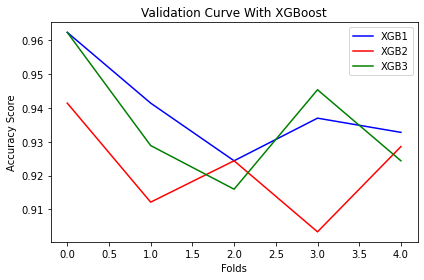

In [100]:
plt.plot(xgb_scores, label='XGB1',color="blue")
plt.plot(xgb_scores2, label='XGB2', color="red")
plt.plot(xgb_scores3, label ='XGB3',color="green")
#plt.plot(xgb_scores4, label = 'XGB3', color='black')
plt.title("Validation Curve With XGBoost")
plt.ylabel("Accuracy Score")
plt.xlabel('Folds')
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [43]:
from sklearn.model_selection import train_test_split
testing_X = news_test['Text']
testing_y = df_clean['category_id'] 

from sklearn.model_selection import train_test_split
X = prepared_df['text']
y = df_clean['category_id']


train, test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

val_X = vectorizer.fit_transform(train)
X_test = vectorizer.transform(test)
#testing = vectorizer.transform(news_test['Text'])


rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=4, max_depth=1000,max_features=1500,
                                n_jobs=-1,)
rf1= RandomForestClassifier(n_estimators=300, min_samples_leaf=4, max_depth=5000,n_jobs=-1)
rf2= RandomForestClassifier(n_estimators=300, min_samples_leaf=2,n_jobs=-1,)
rf3= RandomForestClassifier(min_samples_leaf=4,n_jobs=-1)
rf4 = RandomForestClassifier()

In [44]:
def display_scores(scores):
    print("Scores:", scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

In [45]:
s = cross_val_score(rf, val_X, y_train, scoring='accuracy', cv=5)
s2 = cross_val_score(rf1, val_X, y_train, scoring='accuracy', cv=5)
s3 = cross_val_score(rf2, val_X, y_train, scoring='accuracy', cv=5)
s4 = cross_val_score(rf3, val_X, y_train, scoring='accuracy', cv=5)
s5 = cross_val_score(rf4, val_X, y_train, scoring='accuracy', cv=5)
display_scores(s)
display_scores(s2)
display_scores(s3)
display_scores(s4)
display_scores(s5)

Scores: [0.958159   0.92468619 0.89495798 0.93277311 0.91176471]
Mean: 0.9244681973207693
Standard Deviation: 0.021148618960811116
Scores: [0.9832636  0.94560669 0.93277311 0.92857143 0.94117647]
Mean: 0.9462782602580783
Standard Deviation: 0.01944384469515686
Scores: [0.9790795  0.94979079 0.93277311 0.94957983 0.94957983]
Mean: 0.9521606131992547
Standard Deviation: 0.014962877837329852
Scores: [0.958159   0.93723849 0.90756303 0.94117647 0.93277311]
Mean: 0.9353820189163532
Standard Deviation: 0.01634940773288522
Scores: [0.9665272  0.93305439 0.92016807 0.92857143 0.92436975]
Mean: 0.9345381667311277
Standard Deviation: 0.016558973908269128


In [64]:
#feature engineering for predicting the labels of the test data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

train_x, valid_x, train_y, valid_y = train_test_split(news_train['Text'], news_train['Category'], test_size=0.2)
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [65]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(news_train['Text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
testing = count_vect.transform(news_test['Text'])

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(news_train['Text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
testing_tfidf = tfidf_vect.transform(news_test['Text'])

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(news_train['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
testing_tfidf_ngram = tfidf_vect_ngram.transform(news_test['Text'])

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(news_train['Text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)
testing_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(news_test['Text'])

/Users/anon/opt/miniconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
dtc_score = cross_val_score(dtc, xtrain_tfidf_ngram, train_y, cv=5, scoring='accuracy')
def display_scores(scores):
    print("Scores:", scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())
display_scores(dtc_score)

Scores: [0.67364017 0.66527197 0.60504202 0.61344538 0.58823529]
Mean: 0.6291269645933688
Standard Deviation: 0.03401767764918422


In [68]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    return accuracy_score(predictions, valid_y)

In [73]:
dt_accuracy1 = train_model(DecisionTreeClassifier(criterion='gini'), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", dt_accuracy1)
dt_accuracy2 = train_model(DecisionTreeClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", dt_accuracy2)
dt_accuracy3 = train_model(DecisionTreeClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", dt_accuracy3)


RF, WordLevel TF-IDF:  0.7416107382550335
RF, WordLevel TF-IDF:  0.7416107382550335
RF, WordLevel TF-IDF:  0.7416107382550335
RF, WordLevel TF-IDF:  0.7416107382550335
RF, WordLevel TF-IDF:  0.7416107382550335


Depth:  10
Training accuracy:  100.0 %
Validation accuracy:  71.14131008051757 %
Depth:  25
Training accuracy:  100.0 %
Validation accuracy:  70.88850603002707 %
Depth:  50
Training accuracy:  100.0 %
Validation accuracy:  70.30273197144966 %
Depth:  75
Training accuracy:  100.0 %
Validation accuracy:  71.13990366020886 %
Depth:  100
Training accuracy:  100.0 %
Validation accuracy:  71.05622165184066 %
Depth:  125
Training accuracy:  100.0 %
Validation accuracy:  71.47498329875883 %
Depth:  150
Training accuracy:  100.0 %
Validation accuracy:  71.30761928202244 %


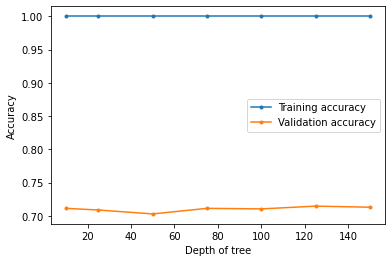

In [89]:
def dtc_parameter_tune(xtrain_tfidf, train_y):
    depths = [10, 25, 50, 75, 100, 125, 150]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = xtrain_tfidf[train_index,:]
            val_X = xtrain_tfidf[val_index,:]

            train_Y = train_y[train_index]
            val_y = train_y[val_index]
            
            dtc = DecisionTreeClassifier(criterion='entropy')
            dtc.fit(train_X, train_Y)
            train_acc.append(dtc.score(train_X, train_Y))
            val_acc.append(dtc.score(val_X, val_y))
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("Depth: ", depth)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(xtrain_tfidf, train_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

Depth:  10
Training accuracy:  96.51848625437492 %
Validation accuracy:  73.65915403818431 %
Depth:  25
Training accuracy:  96.62324206247071 %
Validation accuracy:  70.72325164375373 %
Depth:  50
Training accuracy:  96.64405243509957 %
Validation accuracy:  71.8149854083893 %
Depth:  75
Training accuracy:  96.97994416836605 %
Validation accuracy:  72.31778066875286 %
Depth:  100
Training accuracy:  96.39259009945421 %
Validation accuracy:  71.7313034000211 %
Depth:  125
Training accuracy:  96.83303965629888 %
Validation accuracy:  70.22045638339017 %
Depth:  150
Training accuracy:  96.5813133412967 %
Validation accuracy:  69.21662388804896 %


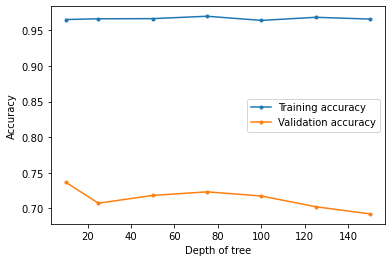

In [81]:
def dtc_parameter_tune(xtrain_tfidf, train_y):
    depths = [10, 25, 50, 75, 100, 125, 150]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = xtrain_tfidf[train_index,:]
            val_X = xtrain_tfidf[val_index,:]

            train_Y = train_y[train_index]
            val_y = train_y[val_index]
            
            dtc = DecisionTreeClassifier(criterion='entropy', max_features = 2000, min_samples_leaf=2)
            dtc.fit(train_X, train_Y)
            train_acc.append(dtc.score(train_X, train_Y))
            val_acc.append(dtc.score(val_X, val_y))
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("Depth: ", depth)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(xtrain_tfidf, train_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

Depth:  10
Training accuracy:  90.79292799303096 %
Validation accuracy:  74.83316339087936 %
Depth:  25
Training accuracy:  90.58321839232171 %
Validation accuracy:  75.16789142435216 %
Depth:  50
Training accuracy:  90.33116210312355 %
Validation accuracy:  74.67072184522344 %
Depth:  75
Training accuracy:  90.52036930712018 %
Validation accuracy:  71.73060018986675 %
Depth:  100
Training accuracy:  90.3526764207039 %
Validation accuracy:  71.05622165184066 %
Depth:  125
Training accuracy:  90.18476355149028 %
Validation accuracy:  73.07232516437537 %
Depth:  150
Training accuracy:  90.7508452838988 %
Validation accuracy:  71.56393938328469 %


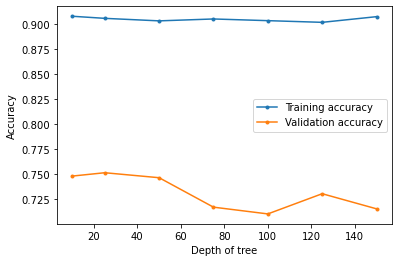

In [94]:
def dtc_parameter_tune(xtrain_tfidf, train_y):
    depths = [10, 25, 50, 75, 100, 125, 150]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = xtrain_tfidf[train_index,:]
            val_X = xtrain_tfidf[val_index,:]

            train_Y = train_y[train_index]
            val_y = train_y[val_index]
            
            dtc = DecisionTreeClassifier(max_features = 1000, min_samples_leaf = 4)
            dtc.fit(train_X, train_Y)
            train_acc.append(dtc.score(train_X, train_Y))
            val_acc.append(dtc.score(val_X, val_y))
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("Depth: ", depth)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(xtrain_tfidf, train_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

In [113]:
# RF on Count Vectors
rf_accuracy = train_model(RandomForestClassifier(n_estimators=500), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", rf_accuracy)

# RF on Word Level TF IDF Vectors
rf_accuracy1 = train_model(RandomForestClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", rf_accuracy1)
rf_accuracy2 = train_model(RandomForestClassifier(n_estimators=200, min_samples_leaf = 2), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", rf_accuracy2)
rf_accuracy3 = train_model(RandomForestClassifier(n_estimators=300, min_samples_leaf = 2), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", rf_accuracy3)
rf_accuracy4 = train_model(RandomForestClassifier(n_estimators=400, min_samples_leaf=4), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", rf_accuracy4)
rf_accuracy5 = train_model(RandomForestClassifier(n_estimators=500, min_samples_leaf=5), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", rf_accuracy5)
rf_accuracy6 = train_model(RandomForestClassifier(n_estimators=600, min_samples_leaf=2), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", rf_accuracy6)

RF, Count Vectors:  0.9630872483221476
RF, WordLevel TF-IDF:  0.9530201342281879
RF, WordLevel TF-IDF:  0.9563758389261745
RF, WordLevel TF-IDF:  0.9463087248322147
RF, WordLevel TF-IDF:  0.9496644295302014
RF, WordLevel TF-IDF:  0.9429530201342282
RF, WordLevel TF-IDF:  0.959731543624161


In [114]:
rf1 = RandomForestClassifier()
rf2= RandomForestClassifier(n_estimators=200, min_samples_leaf=2)
rf3= RandomForestClassifier(n_estimators=300, min_samples_leaf=2)
rf4= RandomForestClassifier(n_estimators=400, min_samples_leaf=3)
rf5 = RandomForestClassifier(n_estimators=500, min_samples_leaf=4)
rf6 = RandomForestClassifier(n_estimators=600, min_samples_leaf=5)



rs1 = cross_val_score(rf1, xtrain_tfidf, train_y, scoring='accuracy', cv=5)
rs2 = cross_val_score(rf2, xtrain_tfidf, train_y, scoring='accuracy', cv=5)
rs3 = cross_val_score(rf3, xtrain_tfidf, train_y, scoring='accuracy', cv=5)
rs4 = cross_val_score(rf4, xtrain_tfidf, train_y, scoring='accuracy', cv=5)
rs5 = cross_val_score(rf5, xtrain_tfidf, train_y, scoring='accuracy', cv=5)
rs6 = cross_val_score(rf6, xtrain_tfidf, train_y, scoring='accuracy', cv=5)
display_scores(rs1)
display_scores(rs2)
display_scores(rs3)
display_scores(rs4)
display_scores(rs5)
display_scores(rs6)

Scores: [0.91213389 0.94979079 0.95378151 0.93697479 0.94957983]
Mean: 0.94045216412925
Standard Deviation: 0.015246065648726204
Scores: [0.92887029 0.94560669 0.94957983 0.94537815 0.96218487]
Mean: 0.9463239689181112
Standard Deviation: 0.0106602890479645
Scores: [0.93723849 0.958159   0.96218487 0.95378151 0.95378151]
Mean: 0.9530290777398825
Standard Deviation: 0.008492579392860234
Scores: [0.94142259 0.94560669 0.95378151 0.94537815 0.94537815]
Mean: 0.9463134207657958
Standard Deviation: 0.0040482465538793115
Scores: [0.94142259 0.94142259 0.97058824 0.95798319 0.95378151]
Mean: 0.9530396258921978
Standard Deviation: 0.010980471753846952
Scores: [0.92050209 0.9539749  0.95378151 0.94537815 0.96218487]
Mean: 0.947164305052565
Standard Deviation: 0.01435167595914007


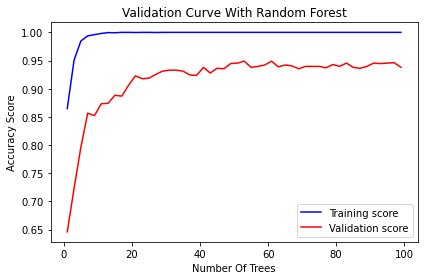

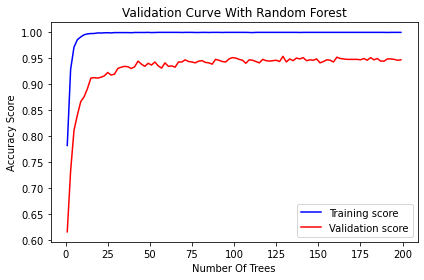

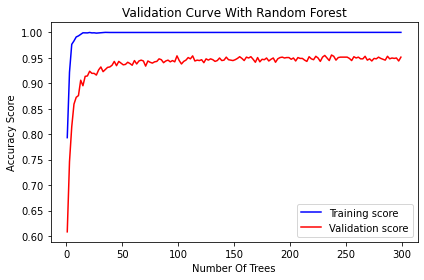

In [98]:
from sklearn.model_selection import validation_curve

param_range1 = np.arange(1, 100, 2)
train_scores1, test_scores1 = validation_curve(rf1,X = xtrain_tfidf, y = train_y,param_name = 'n_estimators',
                                                 param_range=param_range1, cv = 5,scoring="accuracy", 
                                             n_jobs=-1)
train_mean1 = np.mean(train_scores1, axis=1)
train_std1 = np.std(train_scores1, axis=1)
test_mean1 = np.mean(test_scores1, axis=1)
test_std1 = np.std(test_scores1, axis=1)
plt.plot(param_range1, train_mean1, label="Training score", color="blue")
plt.plot(param_range1, test_mean1, label="Validation score", color="red")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

param_range2 = np.arange(1, 200, 2)
train_scores2, test_scores2 = validation_curve(rf2,X = xtrain_tfidf, y = train_y,param_name = 'n_estimators',
                                                 param_range=param_range2, cv = 5,scoring="accuracy", 
                                             n_jobs=-1)
train_mean2 = np.mean(train_scores2, axis=1)
train_std2 = np.std(train_scores2, axis=1)
test_mean2 = np.mean(test_scores2, axis=1)
test_std2 = np.std(test_scores2, axis=1)
plt.plot(param_range2, train_mean2, label="Training score", color="blue")
plt.plot(param_range2, test_mean2, label="Validation score", color="red")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

param_range3 = np.arange(1, 300, 2)
train_scores3, test_scores3 = validation_curve(rf3,X = xtrain_tfidf, y = train_y,param_name = 'n_estimators',
                                                 param_range=param_range3, cv = 5,scoring="accuracy", 
                                             n_jobs=-1)
train_mean3 = np.mean(train_scores3, axis=1)
train_std3 = np.std(train_scores3, axis=1)
test_mean3 = np.mean(test_scores3, axis=1)
test_std3 = np.std(test_scores3, axis=1)
plt.plot(param_range3, train_mean3, label="Training score", color="blue")
plt.plot(param_range3, test_mean3, label="Validation score", color="red")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()





In [72]:

accuracy = train_model(XGBClassifier(learning_rate = 0.1), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)


xgb_accuracy = train_model(XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", xgb_accuracy)
xgb_accuracy1 = train_model(XGBClassifier(learning_rate = 1), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", xgb_accuracy1)
xgb_accuracy2 = train_model(XGBClassifier(learning_rate = 0.8), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", xgb_accuracy2)
xgb_accuracy3 = train_model(XGBClassifier(learning_rate = 0.5), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", xgb_accuracy3)
xgb_accuracy4 = train_model(XGBClassifier(learning_rate = 0.3), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", xgb_accuracy4)
xgb_accuracy5 = train_model(XGBClassifier(learning_rate = 0.01), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", xgb_accuracy5)


accuracy = train_model(XGBClassifier(learning_rate=0.1), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  0.9530201342281879
Xgb, WordLevel TF-IDF:  0.9496644295302014
Xgb, WordLevel TF-IDF:  0.9395973154362416
Xgb, WordLevel TF-IDF:  0.9328859060402684
Xgb, WordLevel TF-IDF:  0.9362416107382551
Xgb, WordLevel TF-IDF:  0.9496644295302014
Xgb, WordLevel TF-IDF:  0.8859060402684564
Xgb, CharLevel Vectors:  0.9261744966442953


In [116]:
xgb_scores1 = cross_val_score(XGBClassifier(),xtrain_tfidf, train_y, scoring = 'accuracy', 
                             cv=5)
xgb_scores2 = cross_val_score(XGBClassifier(learning_rate=1),xtrain_tfidf, train_y, scoring = 'accuracy', 
                             cv=5)
xgb_scores3 = cross_val_score(XGBClassifier(learning_rate=0.1),xtrain_tfidf, train_y, scoring = 'accuracy', 
                             cv=5)
xgb_scores4 = cross_val_score(XGBClassifier(learning_rate=0.01),xtrain_tfidf, train_y, scoring = 'accuracy', 
                             cv=5)
display_scores(xgb_scores1)
display_scores(xgb_scores2)
display_scores(xgb_scores3)
display_scores(xgb_scores4)

Scores: [0.92887029 0.93305439 0.91176471 0.93697479 0.92857143]
Mean: 0.9278471221124434
Standard Deviation: 0.008609826977207474
Scores: [0.91213389 0.93305439 0.92016807 0.92857143 0.92857143]
Mean: 0.9244998417777154
Standard Deviation: 0.007456768656683628
Scores: [0.92887029 0.93305439 0.91176471 0.94117647 0.92857143]
Mean: 0.9286874582468971
Standard Deviation: 0.009606997346211043
Scores: [0.88284519 0.88284519 0.8907563  0.87815126 0.8907563 ]
Mean: 0.8850708484230513
Standard Deviation: 0.0049484664224616086


In [ ]:
plt.plot(xgb_scores, label='XGB1',color="blue")
plt.plot(xgb_scores2, label='XGB2', color="red")
plt.plot(xgb_scores3, label ='XGB3',color="green")
plt.plot(xgb_scores4, label = 'XGB3', color='black')
plt.title("Validation Curve With XGBoost")
plt.ylabel("Accuracy Score")
plt.xlabel('Folds')
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [117]:
rf3.fit(xtrain_tfidf, train_y)

RandomForestClassifier(min_samples_leaf=2, n_estimators=300)

In [118]:
predictions = rf3.predict(testing_tfidf)
predictions

array([3, 4, 3, 0, 3, 3, 2, 2, 1, 0, 0, 4, 2, 4, 1, 3, 2, 4, 1, 1, 0, 2,
       3, 0, 2, 3, 0, 3, 3, 0, 2, 4, 0, 0, 3, 3, 3, 0, 1, 0, 4, 2, 1, 4,
       3, 4, 1, 0, 2, 0, 2, 0, 0, 0, 4, 2, 4, 1, 3, 4, 3, 1, 4, 2, 0, 1,
       3, 4, 3, 3, 0, 3, 0, 2, 4, 3, 4, 4, 4, 1, 2, 3, 1, 3, 4, 1, 0, 1,
       0, 4, 0, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 0, 1, 0, 3, 2, 3, 2, 1,
       3, 0, 1, 3, 2, 3, 2, 3, 2, 0, 1, 0, 1, 1, 4, 3, 0, 1, 0, 1, 0, 2,
       2, 4, 0, 0, 2, 4, 1, 3, 0, 4, 3, 1, 2, 3, 3, 1, 1, 4, 0, 4, 2, 1,
       3, 3, 3, 3, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 4, 2, 0, 2, 0, 0, 1, 2,
       4, 0, 0, 4, 3, 2, 3, 2, 0, 4, 2, 0, 2, 1, 2, 0, 1, 3, 4, 4, 0, 4,
       2, 0, 3, 2, 0, 1, 0, 0, 3, 4, 0, 3, 1, 1, 3, 1, 3, 4, 2, 1, 3, 1,
       3, 1, 2, 0, 4, 2, 0, 2, 0, 4, 0, 3, 2, 2, 0, 2, 3, 0, 1, 2, 3, 2,
       0, 3, 4, 0, 2, 0, 2, 0, 0, 3, 4, 2, 1, 4, 1, 4, 3, 3, 4, 3, 3, 3,
       1, 3, 2, 4, 0, 3, 0, 3, 0, 3, 1, 0, 0, 1, 2, 0, 3, 3, 4, 3, 3, 1,
       0, 3, 4, 2, 1, 0, 0, 2, 3, 1, 0, 0, 3, 3, 4,

In [119]:
predictions_test = encoder.inverse_transform(predictions)

In [120]:
predictions_test

array(['sport', 'tech', 'sport', 'business', 'sport', 'sport', 'politics',
       'politics', 'entertainment', 'business', 'business', 'tech',
       'politics', 'tech', 'entertainment', 'sport', 'politics', 'tech',
       'entertainment', 'entertainment', 'business', 'politics', 'sport',
       'business', 'politics', 'sport', 'business', 'sport', 'sport',
       'business', 'politics', 'tech', 'business', 'business', 'sport',
       'sport', 'sport', 'business', 'entertainment', 'business', 'tech',
       'politics', 'entertainment', 'tech', 'sport', 'tech',
       'entertainment', 'business', 'politics', 'business', 'politics',
       'business', 'business', 'business', 'tech', 'politics', 'tech',
       'entertainment', 'sport', 'tech', 'sport', 'entertainment', 'tech',
       'politics', 'business', 'entertainment', 'sport', 'tech', 'sport',
       'sport', 'business', 'sport', 'business', 'politics', 'tech',
       'sport', 'tech', 'tech', 'tech', 'entertainment', 'politics',
   

In [121]:
labels = pd.DataFrame({
    'articleid':news_test['ArticleId'],
    'predictions':predictions_test})
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   articleid    735 non-null    int64 
 1   predictions  735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [122]:
preds = labels['predictions'].copy() 
labels = labels.astype(str)
labels['articleid'] = labels['articleid'].str.cat(preds, sep=",")
labels

,articleid,predictions
0,"1018,sport",sport
1,"1319,tech",tech
2,"1138,sport",sport
3,"459,business",business
4,"1020,sport",sport
...,...,...
730,"1923,business",business
731,"373,entertainment",entertainment
732,"1704,politics",politics
733,"206,business",business


In [123]:
label_results = labels['articleid']
label_results

0             1018,sport
1              1319,tech
2             1138,sport
3           459,business
4             1020,sport
             ...        
730        1923,business
731    373,entertainment
732        1704,politics
733         206,business
734         471,politics
Name: articleid, Length: 735, dtype: object

In [124]:
label_results.to_csv(r'label_results.csv',header=False, index=False)